<a href="https://colab.research.google.com/github/OpusArtisbyRawlz/equity-direction-prediction/blob/main/Copy_of_01_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Exploration - SPY Direction Prediction

# Objective
Explore historical SPY price data and define a binary target variable for next day price direction

## Data Source
- Yahoo Finance (via yfinance)
- Daily OHLCV data

## Prediction Target
- 1 - Next day close > today's close
- 0 - Otherwise

## Exploratory Steps
- Download SPY data
- Inspect missing values
- Plot closing price
- Compute daily returns

In [ ]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

**Download SPY data**

In [ ]:
spy = yf.download("SPY", start="2010-01-01", progress=False)
spy.head()

print(type(spy["Close"]))
print(spy["Close"].head())
print(spy.columns)



/tmp/ipython-input-3773799296.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download("SPY", start="2010-01-01", progress=False)


<class 'pandas.core.frame.DataFrame'>
Ticker            SPY
Date                 
2010-01-04  85.027954
2010-01-05  85.253029
2010-01-06  85.313095
2010-01-07  85.673187
2010-01-08  85.958298
MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY')],
           names=['Price', 'Ticker'])


Here the columns has **multiIndex**. That means labels has more than one level of meaning. Instead of one label, here we have a tuple of labels.This is powerful when considering multiple tickers but in here, it could confuse the code. Hence, this needs to be flatten.

In [ ]:
spy.columns = spy.columns.get_level_values(0)

In [ ]:
spy.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [ ]:
spy.info()
spy.isna().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4025 entries, 2010-01-04 to 2026-01-02
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   4025 non-null   float64
 1   High    4025 non-null   float64
 2   Low     4025 non-null   float64
 3   Open    4025 non-null   float64
 4   Volume  4025 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 188.7 KB


,0
Price,
Close,0
High,0
Low,0
Open,0
Volume,0


<function matplotlib.pyplot.show(close=None, block=None)>

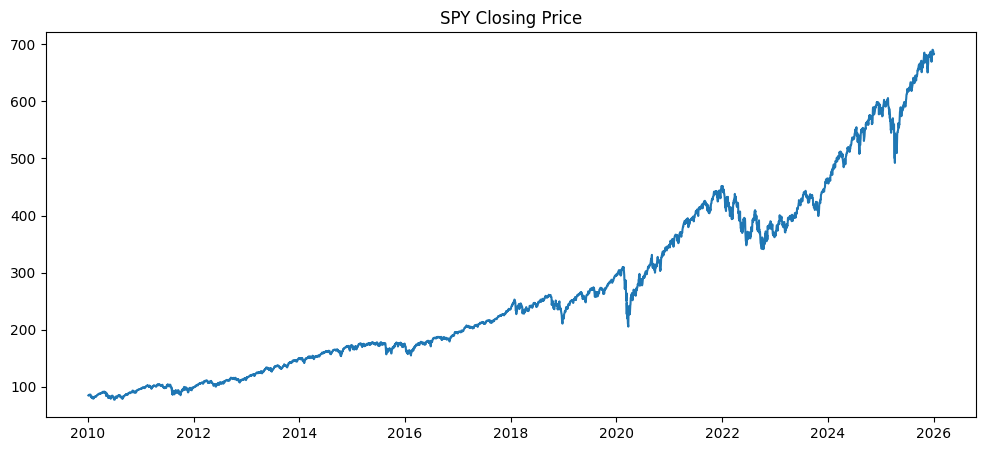

In [ ]:
# Plot close price

plt.figure(figsize=(12,5))
plt.plot(spy["Close"])
plt.title("SPY Closing Price")
plt.show

**Creating Target Variable**

**DATASET V1**

In [ ]:
spy_v1 = spy.copy()
spy_v1["Target"] = (spy_v1["Close"].shift(-1) > spy_v1["Close"]).astype(int)
spy_v1[["Close", "Target"]].head()

Price,Close,Target
Date,,
2010-01-04,85.027954,1
2010-01-05,85.253029,1
2010-01-06,85.313095,1
2010-01-07,85.673187,1
2010-01-08,85.958298,1


In [ ]:
spy_v1["Target"].value_counts(normalize=True)


,proportion
Target,
1,0.554037
0,0.445963


<Axes: title={'center': 'SPY Closing Price'}, xlabel='Date'>

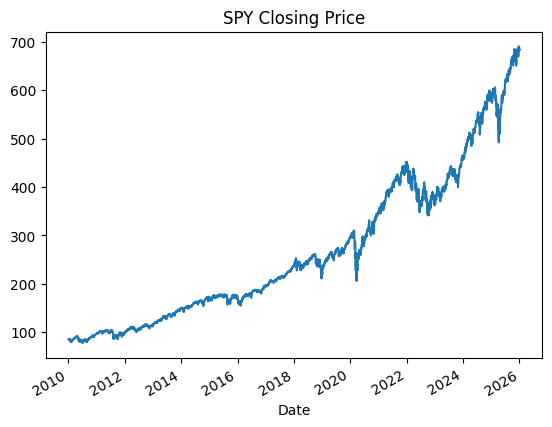

In [ ]:
spy_v1["Close"].plot(title="SPY Closing Price")

**Creating basic features**

**Dataset v1**

In [ ]:
spy_v1["Return_1d"] = spy_v1["Close"].pct_change()
spy_v1["Return_5d"] = spy_v1["Close"].pct_change(5)

spy_v1 = spy_v1.dropna()

**Create X and y**

In [ ]:
X_v1 = spy_v1[["Return_1d", "Return_5d"]]
y_v1 = spy_v1["Target"]


In [ ]:
split = int(len(spy_v1) * 0.8)

X_train, X_test = X_v1.iloc[:split], X_v1.iloc[split:]
y_train, y_test = y_v1.iloc[:split], y_v1.iloc[split:]

**Train Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

**Model accuracy with respect to baseline**

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"{accuracy * 100:.3f}%")



56.343%


The model has an accuracy of 56.179% which is slightly above the baseline

**Calculating Model coefficient**

In [ ]:
pd.Series(model.coef_[0], index=X_v1.columns)

,0
Price,
Return_1d,-0.515791
Return_5d,-0.641255


**Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
TN, FP, TP, FN = cm.ravel()



In [ ]:
import numpy as np
np.unique(y_pred, return_counts=True)


(array([1]), array([804]))

In [ ]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([351, 453]))

In [ ]:
spy_v1["Return_1d"].mean(), spy_v1["Return_5d"].mean()

(np.float64(0.0005747252603982834), np.float64(0.002848915161538198))

From the above, its noticed that means of the return are close to zero. hence it could indicate that there willbe an intercept dominance within the model.

<Axes: >

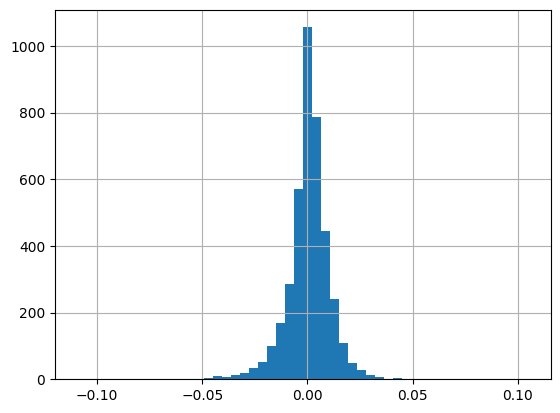

In [ ]:
spy_v1["Return_1d"].hist(bins=50)

In [ ]:
baseline_prob = y_train.mean()
baseline_prob

np.float64(0.5509950248756219)

In [ ]:
y_prob = model.predict_proba(X_test)[:1]
print(y_prob.min(),y_prob.mean(),y_prob.max())

0.45297088161353816 0.5 0.5470291183864618


Here the intercept defines the center of belief, hence the intercept dominates market's average belief and features only creates small deviations. Intercept dominance usually indicates weak but honest features: this does not imply the model is useless.

**Model Flexibility Check**

In [ ]:
from sklearn.metrics import log_loss

for C in [0.1, 1, 10]:
  m = LogisticRegression(C=C, max_iter=2000)
  m.fit(X_train, y_train)

  prob = m.predict_proba(X_test)[:, 1]
  print(f"C={C}, logloss = {log_loss(y_test, prob)}")

C=0.1, logloss = 0.6854022397883016
C=1, logloss = 0.6855097801464282
C=10, logloss = 0.6859097627371894


Logloss is identical across increasing C bit slightly worsening as C increases. Model is not underfitting due to strong regularisation and coefficiants are not being aertificially suppressed. Performance is therefore limited by feature information rather than model configuration.

**Inspect Coefficients**

In [ ]:
import pandas as pd

coef = pd.Series(model.coef_[0], index=X_v1.columns)
print(coef)
model.intercept_

Price
Return_1d   -0.515791
Return_5d   -0.641255
dtype: float64


array([0.20649248])

Although, the feature coefficients are non zero, the return features mean zero in the data cancels out. As a result, the intercept dominates the average prediction.

**Walk Forward Validation**

In [ ]:
def walk_forward_logloss_with_baseline(X, y, train_size=2000, test_size=252, C=1.0, scale=False):
  base_losses = []
  model_losses = []
  start = 0

  while start + train_size + test_size <= len(X):
    X_train = X.iloc[start:start+train_size]
    y_train = y.iloc[start:start+train_size]
    X_test = X.iloc[start+train_size:start+train_size+test_size]
    y_test = y.iloc[start+train_size:start+train_size+test_size]

    #baseline
    p0 = y_train.mean()
    baseline_prob = np.full(len(y_test), p0)
    base_losses.append(log_loss(y_test, baseline_prob))


    #model
    if scale:
      model = make_pipeline(StandardScaler(), LogisticRegression(C=C, max_iter=2000))
    else:
      model = LogisticRegression(C=C, max_iter=2000)

    model.fit(X_train, y_train)
    prob = model.predict_proba(X_test)[:, 1]
    model_losses.append(log_loss(y_test, prob))

    start += test_size

  return np.array(model_losses), np.array(base_losses)


In [ ]:
model_losses, base_losses = walk_forward_logloss_with_baseline(X_v1, y_v1, scale=False)
print("Num Windows", len(model_losses))
print("Model Mean:", model_losses.mean(), "std:", model_losses.std())
print("Base Mean:", base_losses.mean(), "std:", base_losses.std())
print("Mean Improvement (base - model):", (base_losses - model_losses).mean())

Num Windows 8
Model Mean: 0.6875904938307456 std: 0.010915638560358227
Base Mean: 0.6876252124177553 std: 0.010863730925461584
Mean Improvement (base - model): 3.4718587009846535e-05


Using daily and 5- day return as features produces probability marginally better than the baseline, but the improvement is negligible, indicating that the model is information limited rather than misconfigured.

**Adding Volatility Features**

**Dataset V2**

In [ ]:
spy_v2 = spy_v1.copy()
spy_v2["vol_5d"] = spy_v2["Return_1d"].rolling(5).std()
spy_v2["vol_20d"] = spy_v2["Return_1d"].rolling(20).std()

spy_v2 = spy_v2.dropna()

In [ ]:
X_v2 = spy_v2[["Return_1d", "Return_5d", "vol_5d", "vol_20d"]]
y_v2 = spy_v2["Target"]

In [ ]:
model_losses, base_losses = walk_forward_logloss_with_baseline(X_v2, y_v2, scale=True)
print("Num Windows", len(model_losses))
print("Model Mean:", model_losses.mean(), "std:", model_losses.std())
print("Base Mean:", base_losses.mean(), "std:", base_losses.std())
print("Mean Improvement (base - model):", (base_losses - model_losses).mean())

Num Windows 7
Model Mean: 0.6916937851106277 std: 0.012383353896375359
Base Mean: 0.6883603718439643 std: 0.010582886592444581
Mean Improvement (base - model): -0.003333413266663286


It is observed that including volatility is huting 1 day direction prediction. This has been confirmed by singularly testing the vol_5d and vol_20d and in both case, the model prediction was worse than baseline.

**Dataset v3: Trend Context**

In [ ]:
spy_v3 = spy_v1.copy()
spy_v3["MA_20"] = spy_v3["Close"].rolling(20).mean()
spy_v3["Trend_20"] = (spy_v3["Close"] / spy_v3["MA_20"]) - 1

spy_v3 = spy_v3.dropna()

In [ ]:
X_v3 = spy_v3[["Return_1d", "Return_5d", "Trend_20"]]
y_v3 = spy_v3["Target"]

In [ ]:
model_losses, base_losses = walk_forward_logloss_with_baseline(X_v3, y_v3, scale=True)
print("Num Windows", len(model_losses))
print("Model Mean:", model_losses.mean(), "std:", model_losses.std())
print("Base Mean:", base_losses.mean(), "std:", base_losses.std())
print("Mean Improvement (base - model):", (base_losses - model_losses).mean())

Num Windows 7
Model Mean: 0.6900448037507079 std: 0.012238580423159619
Base Mean: 0.6883603718439643 std: 0.010582886592444581
Mean Improvement (base - model): -0.0016844319067434047


For 1 day prediction on SPY, the trend context had a slightly better logloss than the voltility dataset but worse than the baseline as the model does not improve probabilistic forecasts beyond the drift only baseline

**Dataset v4: Trend Interaction**

In [ ]:
spy_v4 = spy_v3.copy()
spy_v4["Return_1_x_Trend"] = spy_v3["Return_1d"] * spy_v3["Trend_20"]
X_v4 = spy_v4[["Return_1d", "Return_5d", "Trend_20", "Return_1_x_Trend"]]
y_v4 = spy_v4["Target"]

In [ ]:
model_losses, base_losses = walk_forward_logloss_with_baseline(X_v4, y_v4, scale=True)
print("Num Windows", len(model_losses))
print("Model Mean:", model_losses.mean(), "std:", model_losses.std())
print("Base Mean:", base_losses.mean(), "std:", base_losses.std())
print("Mean Improvement (base - model):", (base_losses - model_losses).mean())



Num Windows 7
Model Mean: 0.6914615214881996 std: 0.01142682623335438
Base Mean: 0.6883603718439643 std: 0.010582886592444581
Mean Improvement (base - model): -0.0031011496442352776


In [ ]:
spy_v4_1 = spy_v3.copy()
spy_v4_1["Return_5_x_Trend"] = spy_v3["Return_5d"] * spy_v3["Trend_20"]
X_v4_1 = spy_v4_1[["Return_1d", "Return_5d", "Trend_20", "Return_5_x_Trend"]]
y_v4_1 = spy_v4_1["Target"]

In [ ]:
model_losses, base_losses = walk_forward_logloss_with_baseline(X_v4_1, y_v4_1, scale=True)
print("Num Windows", len(model_losses))
print("Model Mean:", model_losses.mean(), "std:", model_losses.std())
print("Base Mean:", base_losses.mean(), "std:", base_losses.std())
print("Mean Improvement (base - model):", (base_losses - model_losses).mean())


Num Windows 7
Model Mean: 0.6909600515869257 std: 0.011546593716421657
Base Mean: 0.6883603718439643 std: 0.010582886592444581
Mean Improvement (base - model): -0.002599679742961349


From the data, it was observed that the trend interaction of both 1d and 5d did not improve the model log loss even though there was a slight improvement in the 5d model compared to 1d as 1d model appears to be more noisy than the other.

After rigorously testing the dataset with multiple features, I find no edge. Hence, I am shifting from a day-trading to seing trading framework where features will be more informative.

**Dataset v5: 5 Day Target**

In [ ]:
spy_v5 = spy.copy()
spy_v5["Return_1d"] = spy_v5["Close"].pct_change()
spy_v5["Return_5d"] = spy_v5["Close"].pct_change(5)

spy_v5["Target_5d"] = (spy_v5["Close"].shift(-5) > spy_v5["Close"]).astype(int)

spy_v5 = spy_v5.dropna()


In [ ]:
X_v5 = spy_v5[["Return_1d", "Return_5d"]]
y_v5 = spy_v5["Target_5d"]

In [ ]:
model_losses, base_losses = walk_forward_logloss_with_baseline(X_v5, y_v5, scale=False)
print("Num Windows", len(model_losses))
print("Model Mean:", model_losses.mean(), "std:", model_losses.std())
print("Base Mean:", base_losses.mean(), "std:", base_losses.std())
print("Mean Improvement (base - model):", (base_losses - model_losses).mean())

Num Windows 8
Model Mean: 0.666823799756388 std: 0.03339141317273087
Base Mean: 0.6666762756994649 std: 0.03349001025343628
Mean Improvement (base - model): -0.00014752405692310122


In [ ]:
print(X_v5.shape, y_v5.shape)
print(X_v5.index.equals(y_v5.index))
print(y_v5.value_counts(normalize=True))
print(y_v5.isna().sum())

(4020, 2) (4020,)
True
Target_5d
1    0.613184
0    0.386816
Name: proportion, dtype: float64
0


Here, its observed that Mean improvement is almost zero and model shows an intercept dominance. Std being similar to baseline indicates that there's no overfitting in the data.

**Dataset v6: 5 day Target With Volatility Features**

In [ ]:
spy_v6 = spy_v5.copy()

spy_v6["vol_5d"] = spy_v6["Return_1d"].rolling(5).std()
spy_v6["vol_20d"] = spy_v6["Return_1d"].rolling(20).std()

spy_v6 = spy_v6.dropna()

In [ ]:
X_v6 = spy_v6[["Return_1d", "Return_5d", "vol_5d", "vol_20d"]]
y_v6 = spy_v6["Target_5d"]

In [ ]:
model_losses, base_losses = walk_forward_logloss_with_baseline(X_v6, y_v6, scale=True)
print("Num Windows", len(model_losses))
print("Model Mean:", model_losses.mean(), "std:", model_losses.std())
print("Base Mean:", base_losses.mean(), "std:", base_losses.std())
print("Mean Improvement (base - model):", (base_losses - model_losses).mean())

Num Windows 7
Model Mean: 0.6803324534978117 std: 0.03570438383559811
Base Mean: 0.6693109823864257 std: 0.028388967253788373
Mean Improvement (base - model): -0.011021471111385914


Volatillity features not only fail to improve directional prediction, but actively degrade calibration and stability when properly normalized.

**Dataset v7 : Trend Context**

In [ ]:
spy_v7 = spy_v6.copy()

spy_v7["MA_20"] = spy_v7["Close"].rolling(20).mean()
spy_v7["Trend_20"] = (spy_v7["Close"] / spy_v7["MA_20"]) - 1

spy_v7 = spy_v7.dropna()

In [ ]:
X_v7 = spy_v7[["Return_1d", "Return_5d", "Trend_20"]]
y_v7 = spy_v7["Target_5d"]

In [ ]:
model_losses, base_losses = walk_forward_logloss_with_baseline(X_v7, y_v7, scale=True)
print("Num Windows", len(model_losses))
print("Model Mean:", model_losses.mean(), "std:", model_losses.std())
print("Base Mean:", base_losses.mean(), "std:", base_losses.std())
print("Mean Improvement (base - model):", (base_losses - model_losses).mean())

Num Windows 7
Model Mean: 0.6707889329836004 std: 0.023646246570301895
Base Mean: 0.6688874617587589 std: 0.023710250827694224
Mean Improvement (base - model): -0.001901471224841538


**Trend Regime Split**

In [ ]:
spy_reg = spy_v7.copy()

#split the data into regimes

bull = spy_reg[spy_reg["Trend_20"] > 0]
bear = spy_reg[spy_reg["Trend_20"] <= 0]

In [ ]:
X_bull = bull[["Return_1d", "Return_5d"]]
y_bull = bull["Target_5d"]

X_bear = bear[["Return_1d", "Return_5d"]]
y_bear = bear["Target_5d"]


In [ ]:
model_losses, base_losses = walk_forward_logloss_with_baseline(X_bull, y_bull,train_size=1000, test_size=126, scale=True)
print("Num Windows", len(model_losses))
print("Model Mean:", model_losses.mean(), "std:", model_losses.std())
print("Base Mean:", base_losses.mean(), "std:", base_losses.std())
print("Mean Improvement (base - model):", (base_losses - model_losses).mean())

Num Windows 13
Model Mean: 0.6635528062873406 std: 0.0302396313023781
Base Mean: 0.660992210925865 std: 0.027762630749157885
Mean Improvement (base - model): -0.0025605953614754764


In [ ]:
model_losses, base_losses = walk_forward_logloss_with_baseline(X_bear, y_bear, train_size=1000, test_size=126, scale=True)
print("Num Windows", len(model_losses))
print("Model Mean:", model_losses.mean(), "std:", model_losses.std())
print("Base Mean:", base_losses.mean(), "std:", base_losses.std())
print("Mean Improvement (base - model):", (base_losses - model_losses).mean())

Num Windows 2
Model Mean: 0.6747197043306279 std: 0.04382584522660482
Base Mean: 0.6801716245218236 std: 0.03875298570498398
Mean Improvement (base - model): 0.005451920191195669


During the test regime split set initially with train_size=2000 and test_size=256, the bear showed no of windows = 0. Therefore, testing has been repeated with train_size=1000 and test_size=126 and observed that within bullish regime, model performed worse than base and in bear, model behaved better. However, the number of windows in bear was only two. so further confirmation is required.

In [ ]:
model_losses, base_losses = walk_forward_logloss_with_baseline(X_bull, y_bull,train_size=756, test_size=126, scale=True)
print("Num Windows", len(model_losses))
print("Model Mean:", model_losses.mean(), "std:", model_losses.std())
print("Base Mean:", base_losses.mean(), "std:", base_losses.std())
print("Mean Improvement (base - model):", (base_losses - model_losses).mean())

Num Windows 15
Model Mean: 0.6702777988902954 std: 0.03577404146139485
Base Mean: 0.6672386156138124 std: 0.03423459700112717
Mean Improvement (base - model): -0.003039183276482804


In [ ]:
model_losses, base_losses = walk_forward_logloss_with_baseline(X_bear, y_bear, train_size=756, test_size=126, scale=True)
print("Num Windows", len(model_losses))
print("Model Mean:", model_losses.mean(), "std:", model_losses.std())
print("Base Mean:", base_losses.mean(), "std:", base_losses.std())
print("Mean Improvement (base - model):", (base_losses - model_losses).mean())

Num Windows 3
Model Mean: 0.6967094262368657 std: 0.026617704112145077
Base Mean: 0.6968209704166229 std: 0.032243726709862544
Mean Improvement (base - model): 0.0001115441797573391


In bull regimes, the 5-day directional outcome is best explained by drift alone; short term returns actively degrade probabilistic forecasts.
Any apparent improvement in bearish regime is weak and not statistically reliable.

**Conclusion**

For SPY, both daily and 5-day directional prediction are dominated by drift. Simple technical features and regime conditioning do not add robust incremental information under linear probabilistic models. Volatility is actively misleading for direction, and return-based signals are regime-dependent but not exploitable

# **Final notebook summary**

**Title**

SPY Direction Prediction: A Walk-Forward, Baseline-First Study (1-day vs 5-day horizons)

**Goal**

Build a disciplined baseline-first pipeline to test whether simple technical features can improve probabilistic forecasts of SPY direction beyond drift, using walk-forward validation.

**Dataset**

•	Instrument: SPY (daily close)

•	Features engineered:

o	Return_1d = Close.pct_change()

o	Return_5d = Close.pct_change(5)

o	Vol_5d = rolling_std(Return_1d, 5)

o	Vol_20d = rolling_std(Return_1d, 20)

o	Trend_20 = Close/MA_20 - 1, where MA_20 = rolling_mean(Close, 20)

•	Targets:

o	1-day direction: Target = 1[Close(t+1) > Close(t)]

o	5-day direction: Target_5d = 1[Close(t+5) > Close(t)]


**Methodology (what makes this rigorous)**

•	Train/test split avoided random shuffles due to time-series leakage risk.

•	Used walk-forward validation:

o	train on a rolling historical window

o	test on the next out-of-sample block

o	repeat across time

•	Primary metric: log loss (probability quality), not accuracy.

•	Baseline for every window: predict constant p0 = y_train.mean() (drift baseline).

•	Model: Logistic Regression with optional StandardScaler() in a pipeline.

**Key Findings**

**A) 1-day direction (daily horizon)**

•	Across multiple feature sets (returns, volatility, trend, interactions), models did not beat drift baseline.

•	Adding volatility and interaction terms often worsened log loss and sometimes increased variability across windows.

•	Interpretation:

o	Daily direction is noise-dominated.
o	Drift/intercept dominates; features add little stable incremental information.

**B) 5-day direction (weekly/swing horizon)**

•	Drift baseline is strong (market goes UP more often than DOWN over 5-day windows).

•	Returns-only and trend-added models remained at or slightly worse than the drift baseline in log loss (improvements not robust).

•	Volatility features:

o	With scaling, volatility became actively misleading, degrading mean log loss and increasing variability.

•	Regime split (Trend_20 > 0 vs Trend_20 ≤ 0):

o	Bull regime: return features were consistently harmful vs baseline.

o	Bear regime: any improvement was not stable and disappeared with more windows.

•	Interpretation:

o	Directional predictability for SPY is dominated by drift even at 5-day horizon under simple linear features.

o	Volatility captures risk/uncertainty, not directional bias.

**Conclusions**

•	A disciplined baseline-first approach shows that simple technical features and linear models do not provide robust incremental directional signal for SPY beyond drift.

•	Negative results are meaningful: they identify where signal is weak and prevent feature-fishing.

•	Volatility is better suited for risk forecasting than direction classification.

















